In [87]:
# SIGNATE Student Cup 2021春【予測部門】における解放として有力なkNNと、特長量エンジニアリングについて、以下の記事を参考に学んでいく。
# https://signate.jp/competitions/449/discussions/pseudo-labeling-lb06630

In [88]:
from pathlib import Path
import warnings
from sklearn.svm import SVC, LinearSVC
from sklearn import multiclass
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_sample_weight
import scipy.stats
from sklearn.datasets import load_breast_cancer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
# ワーニングの出力をなくして表示をシンプルにするもの？
# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)

# 今回の分類数。ジャンルの数。
N_CLASSES = 11

# ファイルのインポート
INPUT = Path("input")
df_train = pd.read_csv(INPUT / "train.csv")
df_test = pd.read_csv(INPUT / "test.csv")
print(df_test.describe())
df_sample_sub = pd.read_csv(INPUT / "sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv(INPUT / "genre_labels.csv")


# trainデータとtestデータをミックスしている。
# 特長量エンジニアリングを別々にやるのは面倒なので、ここで合体させて、学習時に分けるようにしていると思われる。賢い。
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

# 合体させたときにgenre=-100にしているので、それを起点にtrainデータとtestデータを分ける。
def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test


# parameters

# def lgb_metric(preds, data):  
#     pred_labels = preds.reshape(N_CLASSES, -1).argmax(axis=0)
#     score = f1_score(data.get_label(), pred_labels, average="macro")
#     return "macro_f1", score, True

# 以下、lightGBMの学習時のパラメータ定義
learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
}

#k近傍法のグループ数?
knn_n_neighbors = 6


# parameters - knn feature weights
# 以下、kNNの学習時のパラメータ定義。regionはラベルエンコーディング、その他の量的変数は標準化、それ以外にnanの数も特徴量として使っている。
knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

dict_feature_weights = {}

# regionの特長量重みを設定。
# 以下のように重みを決めていくことができるらしい。
# 重みですが、最初に大まかに当たりをつけ(regionは違うものが近傍データとして選ばれないくらい大きめ、popularityも他の特徴より大きめなど)、
# 交差検証での精度を見ながら細かい調整をしています。
for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

# popularityは他の特徴よりも大きめに設定。
dict_feature_weights["standardscaled_popularity"] = 9.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

# acousticnessはlightgbmで重要だったので、大きめに設定。
dict_feature_weights["standardscaled_acousticness"] =3.0

# k近傍法の特徴量重みをnumpy配列に変換。
knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])
print(knn_feature_weights)

# train,testデータに対して特長量エンジニアリングを行うため、合体させる。
df_main = merge_train_test(df_train, df_test)

             index   popularity   duration_ms  acousticness  positiveness  \
count  4046.000000  4046.000000  4.046000e+03   4045.000000   4032.000000   
mean   6068.500000    41.158181  2.418486e+05      0.335216      0.467855   
std    1168.123923    16.107248  7.829733e+04      0.236284      0.220606   
min    4046.000000     0.000000  5.826000e+03      0.012727      0.014537   
25%    5057.250000    31.000000  2.019200e+05      0.145535      0.288579   
50%    6068.500000    42.000000  2.353070e+05      0.245121      0.446927   
75%    7079.750000    52.000000  2.724925e+05      0.494312      0.641742   
max    8091.000000    82.000000  1.105001e+06      0.985922      1.000000   

       danceability     loudness       energy     liveness  speechiness  \
count   4035.000000  4046.000000  4045.000000  4040.000000  4035.000000   
mean       0.499143    -7.636531     0.608755     0.268926     0.201776   
std        0.161413     3.989469     0.200665     0.157032     0.086553   
min   

In [89]:
# 動作検証用のおためし。
df = df_main.copy()
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)
df["tempo"].head()


0    136.5
1    164.5
2     70.0
3    184.5
4    108.5
Name: tempo, dtype: float64

In [90]:
one_rest_f1_final=0.0
#疑似ラベルを使って学習する際の閾値を設定。confidenceがこの閾値を超える場合に、そのラベルを使って学習する。
df = df_main.copy()
# feature engineering
# genreのラベル番号からジャンル名に変換している。
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# ==========================追加==========================
tempo_low = df["tempo"].str.extract('(.+)-', expand=True)
tempo_high = df["tempo"].str.extract('-(.+)', expand=True)
tempo_low = tempo_low.astype(int)
tempo_high = tempo_high.astype(int)
df["tempo_range"] = tempo_high[0] - tempo_low[0]
df["tempo_low"] = tempo_low
df["tempo_high"] = tempo_high
# =============================================================

# tempoの値を平均値に変換している。
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
# regionのone-hotエンコーディング、ついでにunknownの列名を変更している。
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)




df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

class CountEncoder:
    def fit(self, series):
        # "series"ごとの出現回数をカウント
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        # "series"の各要素を、fit時に集計した出現回数に置換
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        # fitとtransformをまとめて実行
        return self.fit(series).transform(series)
columns_count_enc = ["region"]
for col in columns_count_enc:
    # regionの出現回数をカウントして、新しい列を作成している。
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    # 欠損値をnanに変換している。locはnanの行を取得している。
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan

# ===========================ブロンズからの追加===========================
# countenc_regionとpopularityから新たな特徴量を生成する
# 以下のように、regionの出現回数とpopularityの値を掛け合わせることで地域ごとの人気度を表す特徴量を生成している。
# df["popularity_times_countenc_region"] = df["popularity"] * df["countenc_region"]
# ===========================ブロンズからの追加===========================


columns_label_enc = ["region"]
for col in columns_count_enc:
    # regionのラベルエンコーディングを行っている。
    # ラベルエンコーディングとは、カテゴリ変数を数値に変換すること。
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan

class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]

    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        """

        """
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            # group by key
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        """
        Transform evaluation data.
        """
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                # deviationとは、平均からの差分。X - X.mean()
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                # z-scoreとは、平均を引いて標準偏差で割ること。つまりは標準化。
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)   

# tempoを対数変換し特徴量に追加している。
df["log_tempo"] = np.log(df["tempo"])
# カテゴリ変数の特徴量を抽出している。group_keyはregion、group_valuesは特徴量、agg_methodsは標準化。
gfe = GroupFeatureExtractor(
    "region", 
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)
# fit_transformで特徴量を抽出している。
df = pd.concat([df, gfe.fit_transform(df)], axis=1)
# 一旦今のdfの結果を可視化する。
print("add zscore features")

# k近傍法の特徴量を抽出するクラスを作成。
class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)

    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self

    def transform(self, X, is_train_data):
        # kneighborsを使用して距離とindexを取得する。
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)

        return df_knn


# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]


#　特徴量作成用にマージしたデータをtrainデータとtestデータに分ける。
# targetはmulticlassのため、標準化や対数変換を行った予測はできない。
df_train, df_test = split_train_test(df)
target = df_train["genre"]

# 学習前にdf_trainの特徴量を確認
# print(df_train.columns)
# train
# N_SPLITSは交差検証の分割数、SEED_SKFは乱数のシード値。
N_SPLITS = 2
SEED_SKF = 42
np.random.seed(42)

# StratifiedKFoldでデータを分割する。
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
# oofはout of foldの略。交差検証の結果を格納するための変数。
oof = np.zeros((len(df_train), N_CLASSES))
oof_svc = np.zeros((len(df_train), N_CLASSES))
oof_mlp = np.zeros((len(df_train), N_CLASSES))
# 予測結果を格納するための変数。
predictions = np.zeros((len(df_test), N_CLASSES))
predictions_svc = np.zeros((len(df_test), N_CLASSES))
predictions_mlp = np.zeros((len(df_test), N_CLASSES))

# 特徴量の重要度を格納するための変数。
df_feature_importance = pd.DataFrame()

# 量的変数の標準化。SVCやMLPに刺さる。
from sklearn.preprocessing import StandardScaler
# 標準化変換リスト
std_list = ["popularity","duration_ms","acousticness","positiveness","danceability","loudness",
            "energy","liveness","speechiness","instrumentalness","tempo_high","tempo_low","tempo_range",]

scaler = StandardScaler()
scaler.fit(df_train[std_list])
df_train[std_list] = scaler.transform(df_train[std_list])
df_test[std_list] = scaler.transform(df_test[std_list])

# 対数変換
# log_list = ["popularity","duration_ms","acousticness","positiveness","danceability","loudness",
#             "energy","liveness","speechiness","instrumentalness"]
log_list = ["popularity","positiveness", "danceability", "loudness","liveness","speechiness",'tempo_high','tempo_low','tempo_range',]
# popularity lightgbm ダウン、他up
# positiveness lightgbm 変わらず、lightgbm up mlp down
# danceability mlp 他と合わせるとup
# loudness 他と合わせるとup
# liveness svc up mlp ないほうがいい
# speechiness mlp up 他変わらず
# instrumentalness down
df_train[log_list] = np.log(df_train[log_list])
df_test[log_list] = np.log(df_test[log_list])



features_numerical_mlp = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo','tempo_high','tempo_low','tempo_range',
    # regionはラベルエンコーディングされているので、多重共線性を避けるために削除しても良い気がする
    # 'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    # 'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    # 'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    # 'region_S', 'region_T', 
    # 'region_unknown',
    'countenc_region', 
    'num_nans',
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_log_tempo_grpby_region',
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]

# 量的変数の特徴量定義
features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo','tempo_high','tempo_low','tempo_range',
    # regionはラベルエンコーディングされているので、多重共線性を避けるために削除しても良い気がする
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 
    'region_unknown', 'countenc_region', 
    'num_nans',
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_log_tempo_grpby_region',
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]

# カテゴリカル変数の特徴量定義
features_categorical = ["labelenc_region"]
features = features_numerical + features_categorical
features_mlp = features_numerical_mlp + features_categorical



add zscore features


/tmp/ipykernel_266402/1572987571.py:220: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[std_list] = scaler.transform(df_train[std_list])
/tmp/ipykernel_266402/1572987571.py:221: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[std_list] = scaler.transform(df_test[std_list])
/home/denso/anaconda3/envs/kaggle_env/lib/python3.8/site-packages/pandas/core/internals/blocks.py:329: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/tmp/ipykernel_266402/1572987571.

In [91]:

# 交差検証の実行
for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    # 特徴量を制限するかどうかのフラグ
    features_limit = True

    # train dataのindexとvalidation dataのindexを取得して、reset_indexでindexを振り直している。drop=trueは元のindexを削除するため。
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)

    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)

    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    
    #  k近傍法の特徴量を追加
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    df_trn_interpolated= df_trn.copy()
    df_val_interpolated = df_val.copy()
    df_test_interpolated = df_test.copy()

    # 文字列型以外の列を中央値で補完
    for col in df.select_dtypes(exclude='object').columns:
        median = df_trn_interpolated[col].median()
        df_trn_interpolated[col].fillna(median, inplace=True)
        median = df_val_interpolated[col].median()
        df_val_interpolated[col].fillna(median, inplace=True)
        median = df_test_interpolated[col].median()
        df_test_interpolated[col].fillna(median, inplace=True)


    # strなどは中央値で補完できないので、線形補間する。
    df_trn_interpolated = df_trn_interpolated.interpolate(method='linear', limit_direction='both')
    df_val_interpolated = df_val_interpolated.interpolate(method='linear', limit_direction='both')
    df_test_interpolated = df_test_interpolated.interpolate(method='linear', limit_direction='both')

    # 特長量をmlp用に抽出して作成
    if features_limit:
        df_val_interpolated = df_val_interpolated[features_mlp]
        df_test_interpolated = df_test_interpolated[features_mlp]
        df_trn_interpolated = df_trn_interpolated[features_mlp]


    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical,
        # weight=compute_sample_weight(class_weight='balanced', y=target_trn).astype('float32')
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical,
        # reference=lgb_train
    )

    # LightGBM
    print("LightGBM start")
    lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
    evaluation_results = {} # 学習時のスコアを保存する辞書
    model = lgb.train(
        lgb_params,
        lgb_train, 
        num_round, 
        valid_sets=[lgb_train, lgb_valid], 
        callbacks=[lgb.early_stopping(stopping_rounds=50, 
                            verbose=True), # early_stopping用コールバック関数            fobj=None,            
                    lgb.log_evaluation(verbose_eval),
                    lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
        #feval=lgb_metric,
    )
    print("LightGBM end")

    print("SVC start")
    C = 30.0
    ganmma = 0.0005
    # ovo SVC f1:  0.46878
    # RBF
    # One-versus-the-restによる分類
    classifier = SVC(C=C, kernel='rbf', gamma=ganmma, decision_function_shape='ovr', probability=True)

    print("SVC end")
    print("MLP start")
    # 1000、logistic、adam、0.001 、　特長制限f1: 0.56868
    # 1000、logistic、adam、0.001 、　特長全部f1: 0.62275
    mlp_learning_rate = learning_rate + np.random.random() * 0.001  # おまじない

    clf = MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
        beta_2=0.999, early_stopping=False, epsilon=1e-08,
        hidden_layer_sizes=(1000,), learning_rate='constant',
        learning_rate_init=mlp_learning_rate, max_iter=1000, momentum=0.9,
        n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
        random_state=None, shuffle=True, solver='adam', tol=0.0001,
        validation_fraction=0.1, verbose=False, warm_start=False)
    print("MLP end")

    # # 計算に2〜３分かかります。
    # results = []
    # for hidden_layer_sizes in [10, 100, 1000]:
    #     for solver in ['adam']:
    #         for activation in ['identity', 'logistic', 'tanh', 'relu']:
    #             for learning_rate_init in [0.1, 0.01, 0.001]:
    #                 clf = MLPClassifier(max_iter=10000,
    #                     hidden_layer_sizes=(hidden_layer_sizes,), 
    #                     activation=activation, solver=solver,
    #                     learning_rate_init=learning_rate_init)
    #                 clf.fit(df_trn_interpolated.loc[:, features], target_trn)
    #                 pred_y = clf.predict_proba(df_val_interpolated[features])
    #                 score = clf.score(df_trn_interpolated.loc[:, features], target_trn)
    #                 # score = f1_score(target, pred_y.argmax(1), average="macro")
    #                 results.append([hidden_layer_sizes, activation,
    #                     solver, learning_rate_init, score])
    # print(pd.DataFrame([dat for dat in sorted(results, key=lambda f: f[4],
    #             reverse=True)], columns=["hidden_layer_sizes", 
    #             "activation", "solver", "learning_rate_init", "score"]))


    if features_limit:
        classifier.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features_mlp], target_trn)
    else:
        classifier.fit(df_trn_interpolated.loc[:, features], target_trn)
        clf.fit(df_trn_interpolated.loc[:, features], target_trn)

    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    # lightGBM
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    if features_limit:
        oof_mlp[indexes_val] = clf.predict_proba(df_val_interpolated[features_mlp])
        oof_svc[indexes_val] = classifier.predict_proba(df_val_interpolated[features_mlp])
        predictions_svc += classifier.predict_proba(df_test_interpolated[features_mlp]) / N_SPLITS
        predictions_mlp += clf.predict_proba(df_test_interpolated[features_mlp]) / N_SPLITS
    else:
        oof_mlp[indexes_val] = clf.predict_proba(df_val_interpolated[features])
        oof_svc[indexes_val] = classifier.predict_proba(df_val_interpolated[features])
        predictions_svc += classifier.predict_proba(df_test_interpolated[features]) / N_SPLITS
        predictions_mlp += clf.predict_proba(df_test_interpolated[features]) / N_SPLITS


    # 時間かかりすぎるためなし
    # svcのグリッドサーチ
    #条件設定
    # max_score = 0
    # SearchMethod = 0
    # SVC_grid = {SVC(): {"C": [10 ** i for i in range(-1, 2)],
    #                     "kernel": ["linear", "rbf", "sigmoid"],
    #                     "decision_function_shape": ["ovo", "ovr"],
    #                     "random_state": [42]
    #                 }}

    # #グリッドサーチ
    # for model, param in SVC_grid.items():
    #     clf = GridSearchCV(model, param)
    #     clf.fit(df_trn_interpolated.loc[:, features], target_trn)
    #     pred_y = classifier.predict_proba(df_val_interpolated[features])
    #     score = f1_score(target, pred_y.argmax(1), average="macro")
    #     print("parameter is {}".format)
    #     print("f1 score is {}".format(score))

    #     if max_score < score:
    #         max_score = score
    #         best_param = clf.best_params_
    #         best_model = model.__class__.__name__

    #     if max_score < score:
    #         SearchMethod = 1
    #         max_score = score
    #         best_param = clf.best_params_
    #         best_model = model.__class__.__name__

    # if SearchMethod == 0:
    #     print("サーチ方法:グリッドサーチ")
    # else:
    #     print("サーチ方法:ランダムサーチ")
    # print("ベストスコア:{}".format(max_score))
    # print("モデル:{}".format(best_model))
    # print("パラメーター:{}".format(best_param))


# アンサンブルのf1も算出
oof_final = oof*0.6 + oof_svc*0.2 + oof_mlp*0.2
f1 = f1_score(target, oof_final.argmax(1), average="macro")
print(f"oof ansamble f1: {f1}")


------------------------------ fold 0 ------------------------------


/tmp/ipykernel_266402/1150231224.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_266402/1150231224.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
/tmp/ipykernel_266402/1150231224.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

LightGBM start
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[654]	training's multi_logloss: 0.678621	valid_1's multi_logloss: 0.935058
LightGBM end
SVC start
SVC end
MLP start
MLP end
------------------------------ fold 1 ------------------------------


/tmp/ipykernel_266402/1150231224.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


LightGBM start
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[565]	training's multi_logloss: 0.641129	valid_1's multi_logloss: 0.926661
LightGBM end
SVC start
SVC end
MLP start
MLP end
oof ansamble f1: 0.6086388012569924


In [92]:
# lightGBMは自動で特徴選択してくれるので全部入れちゃってok
predict_lgbm = model.predict(df_test[features], num_iteration=prediction_round)

if features_limit:
    predict_svc = classifier.predict_proba(df_test_interpolated[features_mlp])
    predict_mlp = clf.predict_proba(df_test_interpolated[features_mlp])
else:
    predict_svc = classifier.predict_proba(df_test_interpolated[features])
    predict_mlp = clf.predict_proba(df_test_interpolated[features])

# それぞれの予測結果を可視化する。
predict_lgbm = pd.DataFrame(predict_lgbm)
predict_svc = pd.DataFrame(predict_svc)
predict_mlp = pd.DataFrame(predict_mlp)
predict_mlp.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.000687,0.005347,0.012934,0.013683,0.001638,0.151646,0.008858,0.650152,0.089728,0.000507,0.064821
1,0.001399,0.031083,0.040329,0.007994,0.003084,0.002909,0.001687,0.010352,0.720005,0.000737,0.180421
2,0.000489,0.025770,0.014904,0.001996,0.000255,0.003726,0.000826,0.005297,0.299264,0.000101,0.647371
3,0.000320,0.009450,0.029999,0.004489,0.000074,0.010459,0.000178,0.007116,0.059575,0.000014,0.878325
4,0.000230,0.015876,0.007495,0.008570,0.000741,0.001969,0.001466,0.014827,0.861588,0.000144,0.087094


/tmp/ipykernel_266402/470745838.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)
/tmp/ipykernel_266402/470745838.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_svc"] = predictions_svc.argmax(1)
/tmp/ipykernel_266402/470745838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

CV score
  LGBM f1:  0.59656
  SVC f1:  0.55583
  MLP f1:  0.60056

              precision    recall  f1-score   support

           0       0.76      0.59      0.67        32
           1       0.47      0.29      0.36       205
           2       0.57      0.46      0.51       191
           3       0.78      0.68      0.73       362
           4       0.65      0.53      0.59        45
           5       0.64      0.43      0.51       126
           6       0.43      0.24      0.31        50
           7       0.60      0.59      0.59       334
           8       0.67      0.76      0.71      1305
           9       0.78      0.86      0.82        59
          10       0.75      0.78      0.76      1337

    accuracy                           0.69      4046
   macro avg       0.64      0.57      0.60      4046
weighted avg       0.68      0.69      0.68      4046

              precision    recall  f1-score   support

           0       0.78      0.56      0.65        32
          

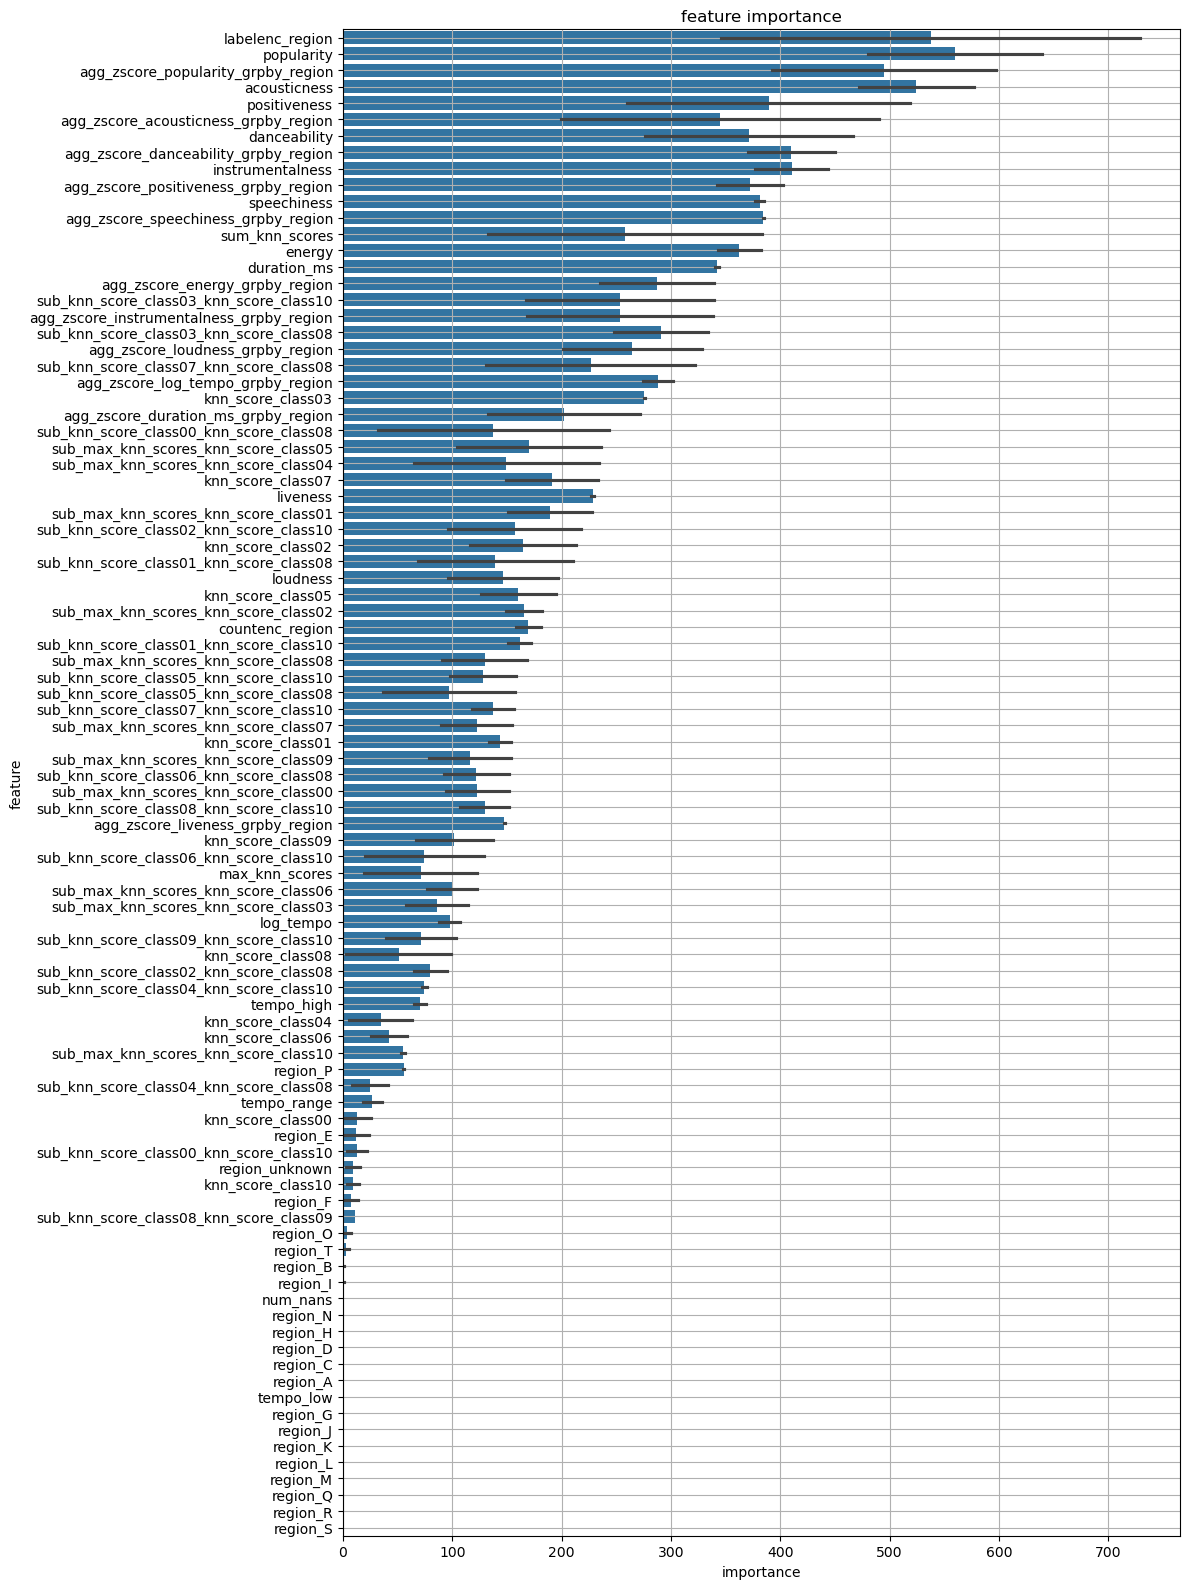

/tmp/ipykernel_266402/470745838.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction_ansamble"] = predictions_final.argmax(1)


In [93]:


df_test["prediction"] = predictions.argmax(1)
df_test["prediction_svc"] = predictions_svc.argmax(1)
df_test["prediction_mlp"] = predictions_mlp.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
score_svc = f1_score(target, oof_svc.argmax(1), average="macro")
score_mlp = f1_score(target, oof_mlp.argmax(1), average="macro")
print("CV score")
print(f"  LGBM f1: {score:8.5f}")
print(f"  SVC f1: {score_svc:8.5f}")
print(f"  MLP f1: {score_mlp:8.5f}")
print()
# 結果をテキストファイルから簡単に確認できるようにtxtにf1 scoreを出力
f = open('f1_score.txt', 'w')
f.write(f"  LGBM f1: {score:8.5f}\n")
f.write(f"  SVC f1: {score_svc:8.5f}\n")
f.write(f"  MLP f1: {score_mlp:8.5f}\n")
# それぞれのパラメータも出力
f.write(f"  LGBM params: {lgb_params}\n")
f.write(f"  SVC params: {classifier}\n")
f.write(f"  MLP params: {clf}\n")

#　重みも出力
f.write(f"  knn_feature_weights: {knn_feature_weights}\n")
f.close()

print(classification_report(target, oof.argmax(1)))
print(classification_report(target, oof_svc.argmax(1)))
print(classification_report(target, oof_mlp.argmax(1)))

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

# mlpとlgbmとsvcの予測結果をアンサンブルする。lightgbmの結果がいいので、重みを調整する。
predictions_final = predictions*0.6 + predictions_mlp*0.2 + predictions_svc*0.2
# predictions_final = (predictions + predictions_mlp + predictions_svc)/3.0
df_test["prediction_ansamble"] = predictions_final.argmax(1)

In [94]:
# すべてのモデルregionワンホットベクトル削除
# CV score
#   LGBM f1:  0.59895
#   SVC f1:  0.46680
#   MLP f1:  0.59975

# lightgbm以外regionワンホットベクトル削除
# CV score
#   LGBM f1:  0.60034
#   SVC f1:  0.46680
#   MLP f1:  0.59975

# すべてワンホットベクトルあり
#   LGBM f1:  0.60059
#   SVC f1:  0.46878
#   MLP f1:  0.58426

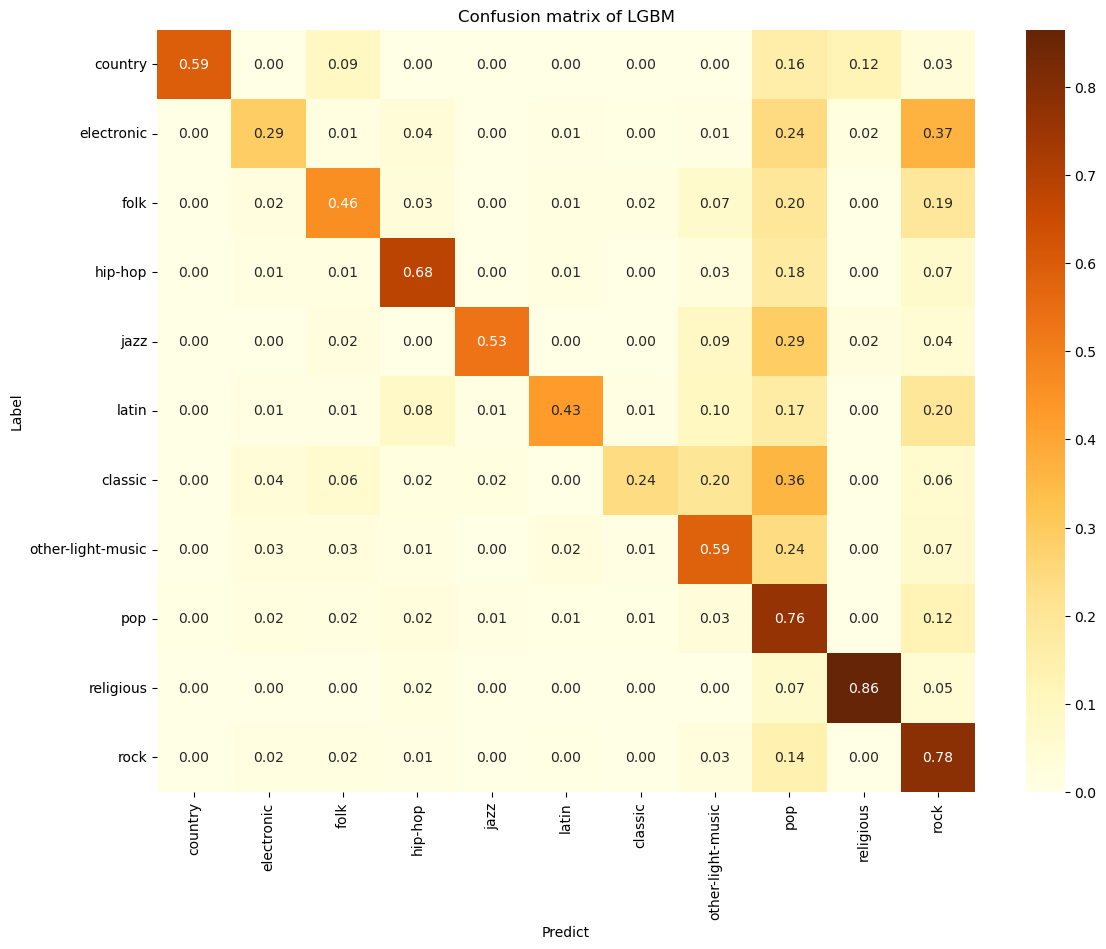

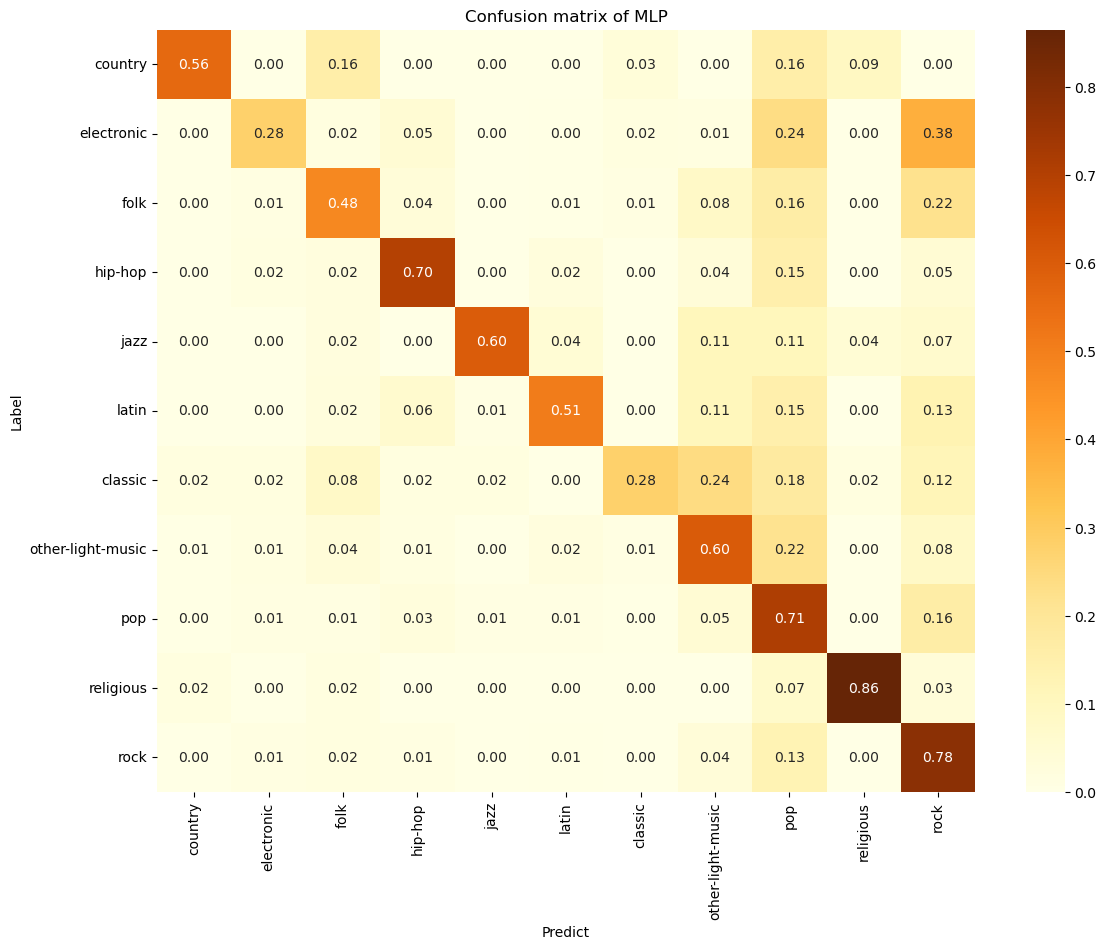

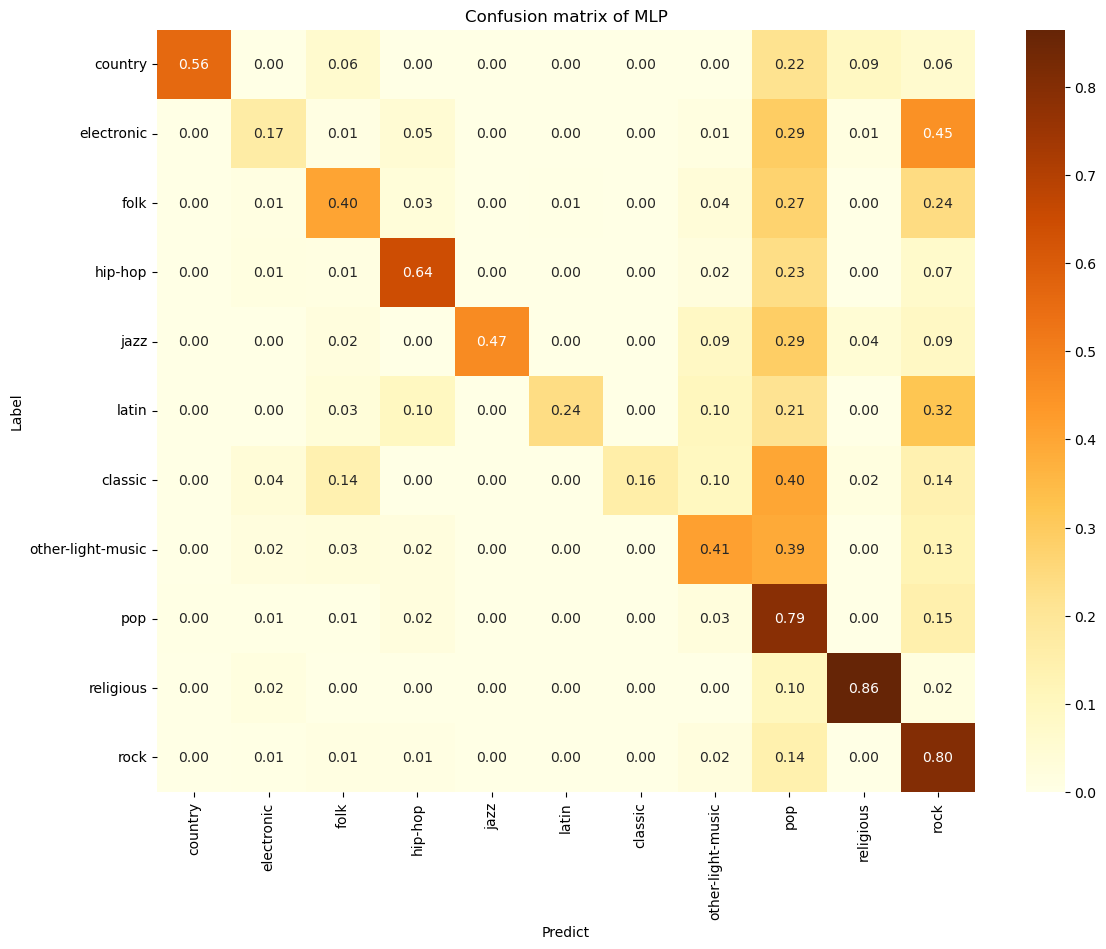

In [95]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None,
                               title="defalut"):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')
    # タイトルを追加
    ax.set_title(title)

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
# SVCの混同行列を可視化
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"], title="Confusion matrix of LGBM")
fig.show()
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_mlp.argmax(1), labels=df_genre_labels["genre"], title="Confusion matrix of MLP")
fig.show()
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_svc.argmax(1), labels=df_genre_labels["genre"], title="Confusion matrix of MLP")
fig.show()


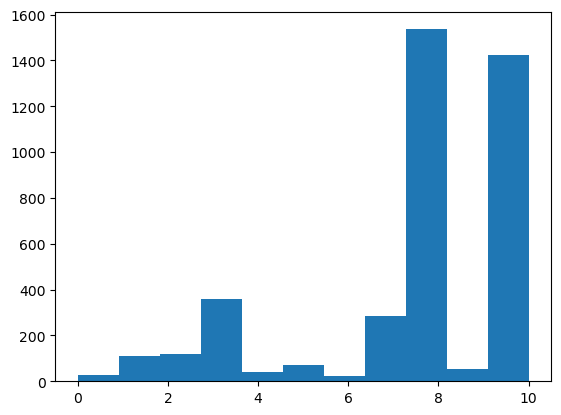

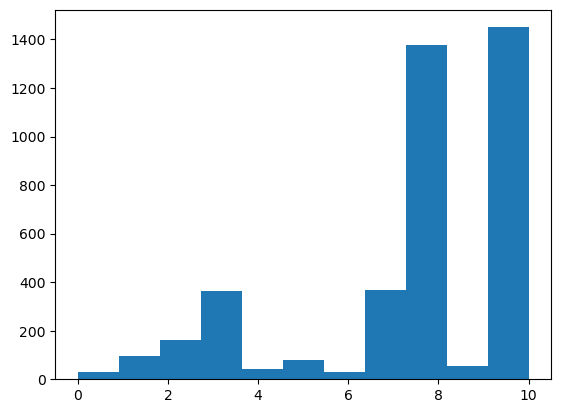

In [96]:
# predictionsのヒストグラムを表示
plt.hist(predictions.argmax(1), bins=11)
plt.show()
# plt.hist(predictions_svc.argmax(1), bins=11)
# plt.show()
plt.hist(predictions_mlp.argmax(1), bins=11)
plt.show()

In [97]:
df_submission = df_sample_sub.copy()
df_submission_mlp = df_sample_sub.copy()
df_submission_ansamble = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
df_submission_mlp["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction_mlp"]].values))
df_submission_ansamble["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction_ansamble"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submission.csv", header=None, index=False)
df_submission_mlp.to_csv("submission_mlp_knn.csv", header=None, index=False)
df_submission_ansamble.to_csv("submission_knn_lgbm_mlp_ansamble.csv", header=None, index=False)




,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,10
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10
